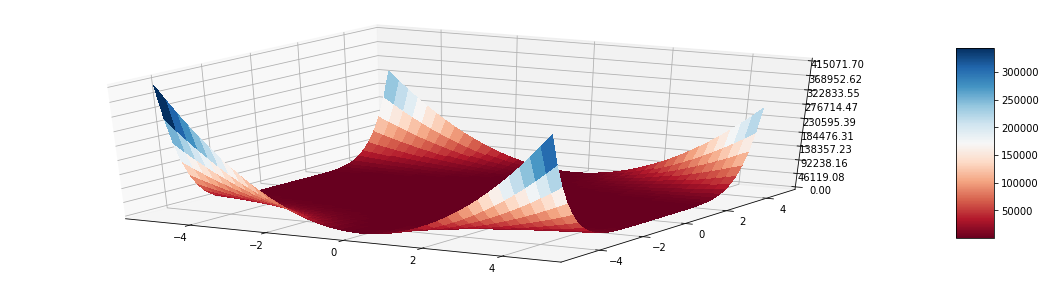

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import random
# objective function
def f(x,y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
x = np.arange(-5, 5, 0.25)
y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(x, y)
Z = f(X,Y)

fig = plt.figure(1, figsize = (20, 5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink = 0.7, aspect=5)
plt.show()

In [125]:
def dfdx(x,y):
    return 2*x

def dfdy(x,y):
    return 2*y

# gradient vector [df/dx, df/dy]
def grad_vector(x,y):
    return np.array([dfdx(x,y), dfdy(x,y)])

In [126]:
def grad_descent_mult(df,x_prev,learn_rate):
    
    epsilon = 0.0001
    grad_itter = 1
    
    seq_x = []
    seq_y = []
    if random.choice([True, False]):
      x_next = np.subtract(x_prev, learn_rate*grad_vector(x_prev[0],0))
    else:
      x_next = np.subtract(x_prev, learn_rate*grad_vector(0,x_prev[1]))
    seq_x = np.append(seq_x, x_next[0])
    seq_y = np.append(seq_y, x_next[1])
    
    while np.linalg.norm(np.subtract(x_next,x_prev)) > epsilon:
        
        x_prev = x_next
        x_next = x_prev - learn_rate*grad_vector(x_prev[0],x_prev[1])
        grad_itter += 1
        
        seq_x = np.append(seq_x, x_next[0])
        seq_y = np.append(seq_y, x_next[1])
    
    return (x_next, grad_itter, seq_x,seq_y)

Minimum (x,y) from gradient descent: [1.31621704e-04 2.63243408e-05]
Number of gradient descent iterations: 22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

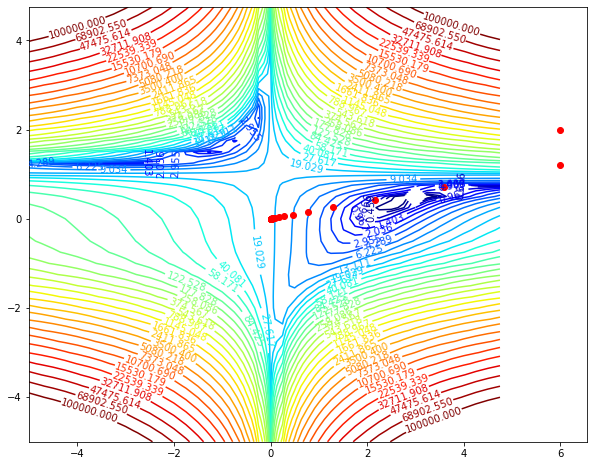

In [127]:
def contour_plot(x_seq,y_seq, x1):
    plt.figure(1)
    plt.subplots(figsize=(10, 8))
    CS = plt.contour(X, Y, Z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=cm.jet)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(x1[0],x1[1],'ro')
    
    plt.plot(x_seq,y_seq,'ro')
    plt.show()

grad_output = grad_descent_mult(grad_vector, np.array([6,2]), 0.2)

print('Minimum (x,y) from gradient descent: %s' %grad_output[0])
print('Number of gradient descent iterations: %s' %grad_output[1])

contour_plot(grad_output[2],grad_output[3], np.array([6,2]))

In [128]:
## ADAM


In [131]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

In [132]:
f = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2


In [146]:
def gradients(x, y):
  """Gradient of Beale function.

  Args:
    x: x-dimension of inputs
    y: y-dimension of inputs

  Returns:
    grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
      dx: gradient of Beale function with respect to x-dimension of inputs
      dy: gradient of Beale function with respect to y-dimension of inputs
  """
  dx = 2. * ( (1.5 - x + x * y) * (y - 1) + \
                (2.25 - x + x * y**2) * (y**2 - 1) + \
                (2.625 - x + x * y**3) * (y**3 - 1) )
  dy = 2. * ( (1.5 - x + x * y) * x + \
              (2.25 - x + x * y**2) * 2. * x * y + \
              (2.625 - x + x * y**3) * 3. * x * y**2 )
  grads = np.array([dx, dy])
  return grads

In [147]:
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
print("minima (1x2 row vector shape): {}".format(minima))
print("minima (2x1 column vector shape):")
print(minima_)

minima (1x2 row vector shape): [3.  0.5]
minima (2x1 column vector shape):
[[3. ]
 [0.5]]


In [148]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

In [149]:
class AdamOptimizer():
  def __init__(self, function, gradients, x_init=None, y_init=None,
               learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.f = function
    self.g = gradients
    scale = 3.0
    self.vars = np.zeros([2])
    if x_init is not None:
      self.vars[0] = x_init
    else:
      self.vars[0] = np.random.uniform(low=-scale, high=scale)
    if y_init is not None:
      self.vars[1] = y_init
    else:
      self.vars[1] = np.random.uniform(low=-scale, high=scale)
    print("x_init: {:.3f}".format(self.vars[0]))
    print("y_init: {:.3f}".format(self.vars[1]))
    
    self.lr = learning_rate
    self.grads_first_moment = np.zeros([2])
    self.grads_second_moment = np.zeros([2])
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    
    # for accumulation of loss and path (w, b)
    self.z_history = []
    self.x_history = []
    self.y_history = []
  
  
  def func(self, variables):
    """Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      z: Beale function value at (x, y)
    """
    x, y = variables
    z = self.f(x, y)
    return z
  
  def gradients(self, variables):
    """Gradient of Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
        dx: gradient of Beale function with respect to x-dimension of inputs
        dy: gradient of Beale function with respect to y-dimension of inputs
    """
    x, y = variables
    grads = self.g(x, y)
    return grads
  
  def weights_update(self, grads, time):
    """Weights update using Adam.
    
      g1 = beta1 * g1 + (1 - beta1) * grads
      g2 = beta2 * g2 + (1 - beta2) * g2
      g1_unbiased = g1 / (1 - beta1**time)
      g2_unbiased = g2 / (1 - beta2**time)
      w = w - lr * g1_unbiased / (sqrt(g2_unbiased) + epsilon)
    """
    self.grads_first_moment = self.beta1 * self.grads_first_moment + \
                              (1. - self.beta1) * grads
    self.grads_second_moment = self.beta2 * self.grads_second_moment + \
                              (1. - self.beta2) * grads**2
    
    self.grads_first_moment_unbiased = self.grads_first_moment / (1. - self.beta1**time)
    self.grads_second_moment_unbiased = self.grads_second_moment / (1. - self.beta2**time)
    
    self.vars = self.vars - self.lr * self.grads_first_moment_unbiased /(np.sqrt(self.grads_second_moment_unbiased) + self.epsilon)
      
  def history_update(self, z, x, y):
    """Accumulate all interesting variables
    """
    self.z_history.append(z)
    self.x_history.append(x)
    self.y_history.append(y)
    

  def train(self, max_steps):
    self.z_history = []
    self.x_history = []
    self.y_history = []
    pre_z = 0.0
    print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(0, self.func(self.vars), self.x, self.y))
    
    file = open('adam.txt', 'w')
    file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
    
    for step in range(max_steps):
      self.z = self.func(self.vars)
      self.history_update(self.z, self.x, self.y)

      self.grads = self.gradients(self.vars)
      self.weights_update(self.grads, step+1)
      file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
      
      if (step+1) % 100 == 0:
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}  dx: {:.5f}  dy: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y, self.dx, self.dy))
        
      if np.abs(pre_z - self.z) < 1e-7:
        print("Enough convergence")
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y))
        self.z = self.func(self.vars)
        self.history_update(self.z, self.x, self.y)
        break
        
      pre_z = self.z
    file.close()

    self.x_history = np.array(self.x_history)
    self.y_history = np.array(self.y_history)
    self.path = np.concatenate((np.expand_dims(self.x_history, 1), np.expand_dims(self.y_history, 1)), axis=1).T
    
    
  @property
  def x(self):
    return self.vars[0]
  
  @property
  def y(self):
    return self.vars[1]
  
  @property
  def dx(self):
    return self.grads[0]
  
  @property
  def dy(self):
    return self.grads[1]

In [150]:
#opt = AdamOptimizer(f, gradients, x_init=0.7, y_init=1.4, learning_rate=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8)
opt = AdamOptimizer(f, gradients, x_init=None, y_init=None, learning_rate=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8) # random initialize

x_init: -0.839
y_init: -1.258


In [151]:
%time
opt.train(1000)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
steps: 0  z: 41.014930  x: -0.83936  y: -1.25834
steps: 100  z: 0.066294  x: 2.51736  y: 0.35602  dx: -0.37001  dy: 0.01717
steps: 200  z: 0.008401  x: 2.79627  y: 0.44468  dx: -0.08900  dy: -0.01520
steps: 300  z: 0.001464  x: 2.90915  y: 0.47649  dx: -0.03290  dy: -0.00496
steps: 400  z: 0.000249  x: 2.96142  y: 0.49024  dx: -0.01283  dy: -0.00185
steps: 500  z: 0.000037  x: 2.98499  y: 0.49624  dx: -0.00481  dy: -0.00068
steps: 600  z: 0.000004  x: 2.99478  y: 0.49870  dx: -0.00165  dy: -0.00023
Enough convergence
steps: 601  z: 0.000004  x: 2.99483  y: 0.49871


In [152]:
print("Global minima")
print("x*: {:.2f}  y*: {:.2f}".format(minima[0], minima[1]))
print("Solution using the gradient descent")
print("x: {:.4f}  y: {:.4f}".format(opt.x, opt.y))

Global minima
x*: 3.00  y*: 0.50
Solution using the gradient descent
x: 2.9948  y: 0.4987


In [153]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

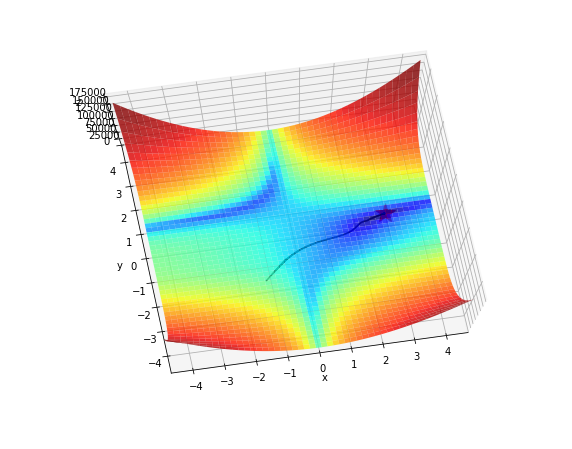

In [154]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

path = opt.path

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=80, azim=-100)

ax.plot_surface(x_mesh, y_mesh, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], opt.func([*path[::,:-1]]),
          path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          opt.func([*path[::,1:]]) - opt.func([*path[::,:-1]]),
          color='k', length=1, normalize=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#plt.draw()
plt.show()

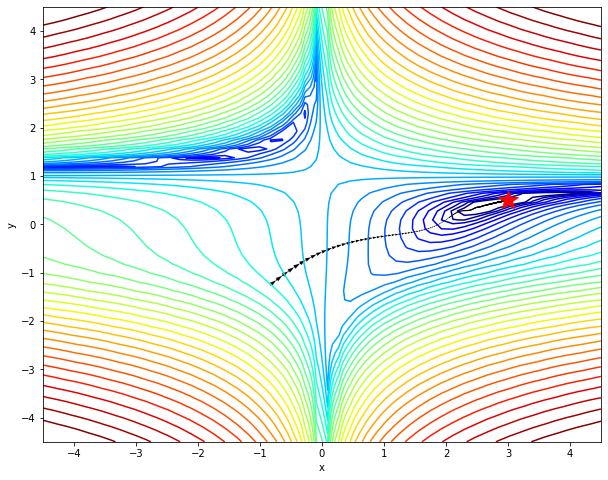

In [155]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          scale_units='xy', angles='xy', scale=1, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

plt.show()